In [176]:
#code adapted from https://nipunbatra.github.io/blog/ml/2020/03/29/param-learning.html
#and http://krasserm.github.io/2018/03/19/gaussian-processes/

#code is plotted with gaussian process utilities library found at: https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/dev/gaussian-processes/gaussian_processes_util.py

#http://www.gaussianprocess.org/gpml/chapters/RW2.pdf was also used for learning purposed


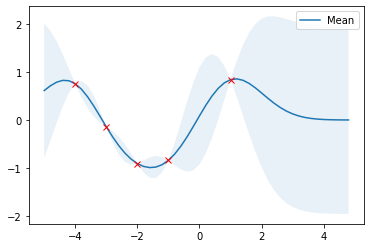

In [177]:
import numpy as np
from gaussian_processes_util import plot_gp
from numpy.linalg import inv

def RBF(X1, X2, l=1.0, sigma_f=1.0):
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    K = RBF(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = RBF(X_train, X_s, l, sigma_f)
    K_ss = RBF(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)

    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s


X_true = np.arange(-5, 5, 0.2).reshape(-1, 1)
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

mu_s, cov_s = posterior(X_true, X_train, Y_train)
plot_gp(mu_s, cov_s, X_true, X_train=X_train, Y_train=Y_train)

Text(0, 0.5, 'Cost')

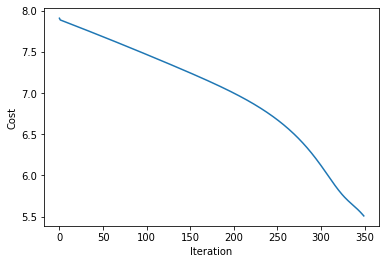

In [178]:
import autograd.numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from autograd import elementwise_grad as egrad
from autograd import grad

def radial_basis_function(x1, x2, sigma, l):
    return (sigma**2)*(np.exp(-(x1-x2)**2/(2*(l**2))))  

def negative_log_likelihood(X, Y, sigma=1, l=1, noise_std=1):
    n = X.shape[0]
    cov = radial_basis_function(X, X.T, sigma, l) + (noise_std**2)*np.eye(X.shape[0])
    nll_ar =  0.5*(Y.T@np.linalg.inv(cov)@Y) + 0.5*n*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(cov)) 
    return nll_ar[0,0]

def gradient_descent(X, Y, g, alpha, max_its, sigma, l):
    noise = 1.0
    gradient = grad(g, argnum=[0, 1, 2])
    cost_history = np.zeros(max_its)
    for iteration in range(max_its):
        cost_history[iteration] = g(X, Y, sigma, l, noise)
        del_sigma, del_l, del_noise = gradient(X, Y, sigma, l, noise)
        sigma = sigma - alpha*del_sigma
        l = l - alpha*del_l
        noise = noise - alpha*del_noise
    return cost_history, l, sigma, noise

X1 = np.array([-4., -3., -2., -1., 1.])[:, None]
Y1 = np.sin(X1) 

cost_history, l2, sigma, _ = gradient_descent(X1, Y1, g = negative_log_likelihood, alpha = 0.01, max_its = 350, sigma =2.0, l = 2.0)
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")

In [179]:
print(l2[0,0], sigma[0,0])

l2, sigma = l2[0,0], sigma[0,0]

1.617214547873207 4.1778110699260305


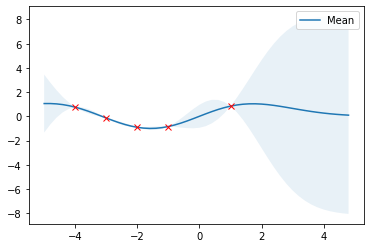

In [180]:
mu_s, cov_s = posterior(X_true, X_train, Y_train, l = l2, sigma_f= sigma)
plot_gp(mu_s, cov_s, X_true, X_train=X_train, Y_train=Y_train)

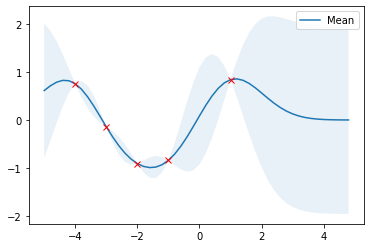

In [181]:
mu_s, cov_s = posterior(X_true, X_train, Y_train)
plot_gp(mu_s, cov_s, X_true, X_train=X_train, Y_train=Y_train)

In [182]:
def aquisition_function(cov_s):
    maxcov = 0
    maxcovind = 0
    for i, x in enumerate(cov_s):
        if np.sum(np.absolute(x)) > maxcov:
            maxcov = np.sum(np.absolute(x))
            maxcovind = i 
    return (maxcovind/5) - 5

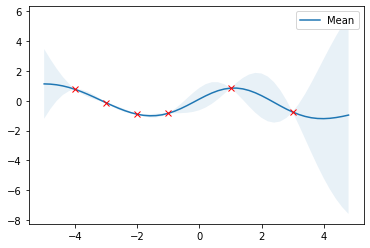

In [183]:
realind = aquisition_function(cov_s)
new_X_train = np.append(X_train, int(realind)).reshape(-1,1)

X1 = np.append(X_train, int(realind))[:, None]
X1 = X1.astype(np.float)
Y1 = np.sin(X1) 

cost_history, l2, sigma, _ = gradient_descent(X1, Y1, g = negative_log_likelihood, alpha = 0.01, max_its = 350, sigma =2.0, l = 2.0)

l2, sigma = l2[0,0], sigma[0,0]
mu_s, cov_s = posterior(X_true, new_X_train, new_Y_train, l = l2, sigma_f= sigma)

plot_gp(mu_s, cov_s, X_true, X_train=new_X_train, Y_train=new_Y_train)

4.800000000000001


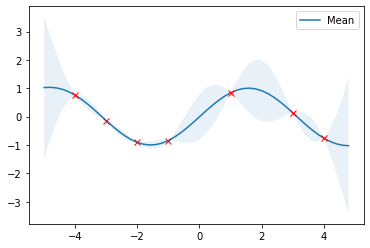

In [184]:
realind = aquisition_function(cov_s)
print(realind)
new_X_train1 = np.append(new_X_train, int(realind)).reshape(-1,1)
new_Y_train1 = np.sin(new_X_train1) 

X1 = np.append(new_X_train, int(realind))[:, None]
X1 = X1.astype(np.float)
Y1 = np.sin(X1) 

cost_history, l2, sigma, _ = gradient_descent(X1, Y1, g = negative_log_likelihood, alpha = 0.01, max_its = 350, sigma =2.0, l = 2.0)

l2, sigma = l2[0,0], sigma[0,0]
mu_s, cov_s = posterior(X_true, new_X_train1, new_Y_train1, l = l2, sigma_f= sigma)

plot_gp(mu_s, cov_s, X_true, X_train=new_X_train1, Y_train=new_Y_train1)